In [1]:
#import
import pandas as pd
import numpy as np
import scipy.io as sio
import os
import h5py
from datetime import *
%matplotlib inline
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.font_manager import FontProperties
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
myfont = FontProperties(fname=r'C:\Windows\Fonts\simhei.ttf', size=10)
sns.set(font=myfont.get_name(),style="whitegrid",palette="muted",color_codes=True)
import warnings
warnings.filterwarnings("ignore")
from statsmodels.regression.linear_model import OLS
import random
from scipy import stats
from scipy.optimize import least_squares
import copy
import math
from sklearn.neighbors import KernelDensity
import scipy.stats
import statsmodels as sm
import QuantLib as ql
import requests
from lxml import etree
from general_function import *

In [2]:
#full_data
os.chdir(r'C:/Users/bj/Desktop/刘泽丹/Code/')
full = pd.read_csv('full_data_for_generator_from_db.csv')
full.columns = [int(i) for i in full.columns]
full[4] = [int(str(date.fromordinal(i-366)).replace('-','')) for i in full[4]]
full.set_index([0,4],inplace=True)
full_nonright = pd.read_csv('full_data_for_mission.csv')
full_nonright.columns = [int(i) for i in full_nonright.columns]
full_nonright[4] = [int(str(date.fromordinal(int(i)-366)).replace('-','')) for i in full_nonright[4]]
full_nonright.set_index([0,4],inplace = True)
return_info = pd.read_csv('full_data.csv')
return_info.set_index(['S_INFO_WINDCODE','TRADE_DT'],inplace=True)
zzIcData = pd.read_csv('zz500_from_db.csv')
zzIcData.columns = [int(i) for i in zzIcData.columns]
zzIcData[1] = [int(str(date.fromordinal(int(i)-366)).replace('-','')) for i in zzIcData[1]]
zzIcData.set_index(1,inplace=True)

In [4]:
dividendyield = pd.read_csv('dividendyield2.csv',index_col = 0)
dividendyield.columns = [int(i) for i in dividendyield.columns]

In [5]:
from WindPy import *
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2017 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [6]:
first_date = '2017-01-02'
last_date = '2019-03-15'
Rdata = w.edb("M0017138", first_date, last_date, "Fill=Previous")
R = pd.DataFrame(Rdata.Data[0], index=Rdata.Times, columns=['R'])['R']
R.index = [int(str(i).replace('-', '')) for i in R.index]
R.to_csv('Shibor_overnight.csv')

In [6]:
R = pd.read_csv('Shibor_overnight.csv',header=None,index_col=0)[1]

In [131]:
class portfolio():
    #initialize as no stock holding and option holding
    #current date is set as real-time today
    #read risk-free rate and stocks' dividend rates for futher use
    def __init__(self):
        self.stock_portfolio = pd.DataFrame()
        self.option_portfolio = pd.DataFrame()
        self.basic_summary = pd.DataFrame()
        self.current_date = datetime.now().year * 10000 + datetime.now().month * 100 + datetime.now().day
        self.background_data = {'r':R, 'q':dividendyield}
    
    #add a stock holding
    def add_stock_term(self, stock_code, stock_shares, stock_start_price, start_date):
        add_stock_df = pd.DataFrame([[stock_code, stock_shares, stock_start_price, start_date]], index = [len(self.stock_portfolio)], \
            columns = ['stock_code', 'stock_shares', 'stock_start_price', 'start_date'])
        self.stock_portfolio = pd.concat([self.stock_portfolio, add_stock_df]).sort_values('stock_code')
        self.combine_stockNoption_portfolio()
        return
    
    #add an option holding
    def add_option_term(self, stock_code, option_shares, stock_start_price, option_strike_price, option_price, start_date, maturity_date, \
        option_type):
        add_option_df = pd.DataFrame([[stock_code, option_shares, stock_start_price, option_strike_price, option_price, start_date, \
            maturity_date, option_type]], index = [len(self.option_portfolio)], columns = ['stock_code', 'option_shares', \
            'stock_start_price', 'option_strike_price', 'option_price', 'start_date', 'maturity_date', 'option_type'])
        self.option_portfolio = pd.concat([self.option_portfolio, add_option_df]).sort_values('stock_code')
        self.combine_stockNoption_portfolio()
        return
    
    #simply combine stock and option holdings together
    def combine_stockNoption_portfolio(self):
        self.basic_summary = pd.concat([self.stock_portfolio,self.option_portfolio]).loc[:,['stock_code', 'start_date', 'maturity_date', \
            'stock_start_price', 'stock_shares', 'option_shares', 'option_strike_price', 'option_price', 'option_type']]\
            .sort_values('stock_code').reset_index(drop = True)
        return
    
    #update real-time current price of stocks/underlying stocks from sina
    def update_current_price(self):
        all_holding_stocks = ''.join(['sz'+'0'*(6 - len(str(stock_code)))+str(stock_code)+',' if stock_code//100000!=6 \
            else 'sh'+str(stock_code)+',' for stock_code in self.basic_summary['stock_code'].unique().tolist()])[:-1]
        r = requests.get('http://hq.sinajs.cn/list='+all_holding_stocks)
        html = etree.HTML(r.content).xpath('/html/body/p/text()')[0].replace('\n','').split(';')[:-1]
        all_holding_stocks_info = pd.Series()
        for stock_info in html:
            try:
                all_holding_stocks_info.loc[int(stock_info.split('=')[0][-6:])] = float(stock_info.split(',')[3])
            except:
                all_holding_stocks_info.loc[int(stock_info.split('=')[0][-6:])] = np.nan
        self.basic_summary['current_price'] = all_holding_stocks_info.loc[self.basic_summary['stock_code']].tolist()
        return
    
    #update current date
    def update_todate(self):
        self.current_date = datetime.now().year * 10000 + datetime.now().month * 100 + datetime.now().day
        return
    
    #get stocks/underlying stocks' history volatility from return_info dataframe
    def update_historyvolatility(self, back_period = 60):
        all_holding_stocks_info = pd.Series()
        for stock_code in self.basic_summary['stock_code'].unique():
            try:
                all_holding_stocks_info.loc[stock_code] = (return_info.xs(stock_code, level = 0)['cc']\
                    [return_info.xs(stock_code, level = 0)['cc'].index<=self.current_date].iloc[-back_period:]/100).std()
            except:
                all_holding_stocks_info.loc[stock_code] = np.nan
        self.basic_summary[str(back_period)+'_history_volatility'] = all_holding_stocks_info.loc[self.basic_summary['stock_code']].tolist()
        return
    
    #update functions all-together
    def update(self):
        self.update_current_price()
        self.update_todate()
        self.update_historyvolatility(5)
        self.update_historyvolatility(10)
        self.update_historyvolatility(20)
        self.update_historyvolatility(60)
        return
    
    #calculate a stock term's current profit&loss
    def calculate_single_profitNloss_stock(self,stock_shares, stock_start_price, stock_current_price):
        return stock_shares * (stock_current_price - stock_start_price)
    
    #calculate an option term's current profit&loss
    def calculate_single_profitNloss_option(self,option_shares, option_strike_price, stock_current_price, option_price, option_type):
        if option_type == 'European-Call' or option_type == 'American-Call':
            if option_shares > 0:
                return option_shares * (max(stock_current_price - option_strike_price, 0) - option_price)
            else:
                return option_shares * (max(stock_current_price - option_strike_price, 0) - option_price)
        elif option_type == 'European-Put' or option_type == 'American-Put':
            if option_shares > 0:
                return option_shares * (max(option_strike_price - stock_current_price, 0) - option_price)
            else:
                return option_shares * (max(option_strike_price - stock_current_price, 0) - option_price)
        else:
            return
    
    def calculate_single_optionprice(self,stock_start_price, stock_volatility, stock_dividend, option_strike_price, option_type, risk_free, \
        calculation_date, maturity_date):
        calculation_date = int(calculation_date)
        maturity_date = int(maturity_date)
        calculation_date = ql.Date(calculation_date%100, calculation_date%10000//100, calculation_date%100000000//10000)
        maturity_date = ql.Date(maturity_date%100, maturity_date%10000//100, maturity_date%100000000//10000)
        day_count = ql.Business252()
        calendar = ql.China()
        ql.Settings.instance().evaluationDate = calculation_date
        if option_type == 'American-Call':
            option_type = ql.Option.Call
            payoff = ql.PlainVanillaPayoff(option_type, option_strike_price)
            exercise = ql.AmericanExercise(calculation_date, maturity_date)
            option_result = ql.VanillaOption(payoff, exercise)
        elif option_type == 'American-Put':
            option_type = ql.Option.Put
            payoff = ql.PlainVanillaPayoff(option_type, option_strike_price)
            exercise = ql.AmericanExercise(calculation_date, maturity_date)
            option_result = ql.VanillaOption(payoff, exercise)
        elif option_type == 'European-Call':
            option_type = ql.Option.Call
            payoff = ql.PlainVanillaPayoff(option_type, option_strike_price)
            exercise = ql.EuropeanExercise(calculation_date, maturity_date)
            option_result = ql.VanillaOption(payoff, exercise)
        elif option_type == 'European-Put':
            option_type = ql.Option.Put
            payoff = ql.PlainVanillaPayoff(option_type, option_strike_price)
            exercise = ql.EuropeanExercise(calculation_date, maturity_date)
            option_result = ql.VanillaOption(payoff, exercise)
        else:
            return
        spot_handle = ql.QuoteHandle(ql.SimpleQuote(stock_start_price))
        riskfree_termstructure = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, risk_free, day_count))
        dividend_termstructure = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, stock_dividend, day_count))
        volatility_termstructure = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(calculation_date, calendar, stock_volatility, \
            day_count))
        bsm_process = ql.BlackScholesMertonProcess(spot_handle, dividend_termstructure, riskfree_termstructure, volatility_termstructure)
        engine = ql.BinomialVanillaEngine(bsm_process, 'crr', 200)
        option_result.setPricingEngine(engine)
        return option_result.NPV()
    
    def calculate_single_greeks(self,stock_start_price, stock_volatility, stock_dividend, option_strike_price, option_type, risk_free, \
        calculation_date, maturity_date):
        calculation_date = int(calculation_date)
        maturity_date = int(maturity_date)
        calculation_date = ql.Date(calculation_date%100, calculation_date%10000//100, calculation_date%100000000//10000)
        maturity_date = ql.Date(maturity_date%100, maturity_date%10000//100, maturity_date%100000000//10000)
        day_count = ql.Business252()
        calendar = ql.China()
        ql.Settings.instance().evaluationDate = calculation_date
        if option_type == 'American-Call':
            option_type = ql.Option.Call
            payoff = ql.PlainVanillaPayoff(option_type, option_strike_price)
            exercise = ql.AmericanExercise(calculation_date, maturity_date)
            option_result = ql.VanillaOption(payoff, exercise)
        elif option_type == 'American-Put':
            option_type = ql.Option.Put
            payoff = ql.PlainVanillaPayoff(option_type, option_strike_price)
            exercise = ql.AmericanExercise(calculation_date, maturity_date)
            option_result = ql.VanillaOption(payoff, exercise)
        elif option_type == 'European-Call':
            option_type = ql.Option.Call
            payoff = ql.PlainVanillaPayoff(option_type, option_strike_price)
            exercise = ql.EuropeanExercise(calculation_date, maturity_date)
            option_result = ql.VanillaOption(payoff, exercise)
        elif option_type == 'European-Put':
            option_type = ql.Option.Put
            payoff = ql.PlainVanillaPayoff(option_type, option_strike_price)
            exercise = ql.EuropeanExercise(calculation_date, maturity_date)
            option_result = ql.VanillaOption(payoff, exercise)
        else:
            return
        spot_handle = ql.QuoteHandle(ql.SimpleQuote(stock_start_price))
        riskfree_termstructure = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, risk_free, day_count))
        dividend_termstructure = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, stock_dividend, day_count))
        volatility_termstructure = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(calculation_date, calendar, stock_volatility, \
            day_count))
        bsm_process = ql.BlackScholesMertonProcess(spot_handle, dividend_termstructure, riskfree_termstructure, volatility_termstructure)
        engine = ql.BinomialVanillaEngine(bsm_process, 'crr', 200)
        option_result.setPricingEngine(engine)
        return option_result
    
    def calculate_single_impliedvolatility(self,stock_start_price, stock_dividend, option_price, option_strike_price, option_type, \
        risk_free, start_date, maturity_date):
        start_date = int(start_date)
        maturity_date = int(maturity_date)
        start_date = ql.Date(start_date%100, start_date%10000//100, start_date%100000000//10000)
        maturity_date = ql.Date(maturity_date%100, maturity_date%10000//100, maturity_date%100000000//10000)
        day_count = ql.Business252()
        calendar = ql.China()
        ql.Settings.instance().evaluationDate = start_date
        if option_type == 'American-Call':
            option_type = ql.Option.Call
            payoff = ql.PlainVanillaPayoff(option_type, option_strike_price)
            exercise = ql.AmericanExercise(start_date, maturity_date)
            option_result = ql.VanillaOption(payoff, exercise)
        elif option_type == 'American-Put':
            option_type = ql.Option.Put
            payoff = ql.PlainVanillaPayoff(option_type, option_strike_price)
            exercise = ql.AmericanExercise(start_date, maturity_date)
            option_result = ql.VanillaOption(payoff, exercise)
        elif option_type == 'European-Call':
            option_type = ql.Option.Call
            payoff = ql.PlainVanillaPayoff(option_type, option_strike_price)
            exercise = ql.EuropeanExercise(start_date, maturity_date)
            option_result = ql.VanillaOption(payoff, exercise)
        elif option_type == 'European-Put':
            option_type = ql.Option.Put
            payoff = ql.PlainVanillaPayoff(option_type, option_strike_price)
            exercise = ql.EuropeanExercise(start_date, maturity_date)
            option_result = ql.VanillaOption(payoff, exercise)
        else:
            return
        spot_handle = ql.QuoteHandle(ql.SimpleQuote(stock_start_price))
        riskfree_termstructure = ql.YieldTermStructureHandle(ql.FlatForward(start_date, risk_free, day_count))
        dividend_termstructure = ql.YieldTermStructureHandle(ql.FlatForward(start_date, stock_dividend, day_count))
        volatility_termstructure = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(start_date, calendar, 0.4, day_count))
        bsm_process = ql.BlackScholesMertonProcess(spot_handle, dividend_termstructure, riskfree_termstructure, volatility_termstructure)
        engine = ql.BinomialVanillaEngine(bsm_process, 'crr', 200)
        option_result.setPricingEngine(engine)
        return option_result.impliedVolatility(option_price, bsm_process)
    
    def calculate_profitNloss(self):
        profitNloss_list = []
        for i in self.basic_summary.index:
            if pd.isnull(self.basic_summary.loc[i, 'option_shares']):
                profitNloss_list.append(self.calculate_single_profitNloss_stock(\
                    stock_shares = self.basic_summary.loc[i, 'stock_shares'], \
                    stock_start_price = self.basic_summary.loc[i, 'stock_start_price'], \
                    stock_current_price = self.basic_summary.loc[i, 'current_price']))
            else:
                profitNloss_list.append(self.calculate_single_profitNloss_option(\
                    option_shares = self.basic_summary.loc[i, 'option_shares'], \
                    option_strike_price = self.basic_summary.loc[i, 'option_strike_price'], \
                    stock_current_price = self.basic_summary.loc[i, 'current_price'], \
                    option_price = self.basic_summary.loc[i, 'option_price'], \
                    option_type = self.basic_summary.loc[i, 'option_type']))
        self.basic_summary['profit_loss'] = profitNloss_list
        return
    
    def calculate_greeks(self, volatility_type = 'implied_volatility'):
        if volatility_type == 'implied_volatility':
            self.calculate_impliedvolatility()
        elif type(volatility_type) == int and volatility_type > 1:
            self.update_historyvolatility(volatility_type)
            volatility_type = str(volatility_type) + '_history_volatility'
        delta_list = []
        gamma_list = []
        theta_list = []
        vega_list = []
        rho_list = []
        for i in self.basic_summary.index:
            if pd.isnull(self.basic_summary.loc[i, 'option_shares']):
                delta_list.append(self.basic_summary.loc[i, 'stock_shares'])
                gamma_list.append(0)
                theta_list.append(0)
                vega_list.append(0)
                rho_list.append(0)
            else:
                option_result = self.calculate_single_greeks(\
                    stock_start_price = self.basic_summary.loc[i, 'stock_start_price'], \
                    stock_volatility = self.basic_summary.loc[i, volatility_type], \
                    stock_dividend = self.background_data['q'].loc[self.basic_summary.loc[i,'start_date'],\
                                                                   self.basic_summary.loc[i,'stock_code']]/100, \
                    option_strike_price = self.basic_summary.loc[i, 'option_strike_price'], \
                    option_type = self.basic_summary.loc[i, 'option_type'], \
                    risk_free = self.background_data['r'].loc[self.basic_summary.loc[i, 'start_date']]/100, \
                    calculation_date = self.current_date, \
                    maturity_date = self.basic_summary.loc[i, 'maturity_date'])
                original = self.calculate_single_optionprice(\
                    stock_start_price = self.basic_summary.loc[i, 'stock_start_price'], \
                    stock_volatility = self.basic_summary.loc[i, volatility_type], \
                    stock_dividend = self.background_data['q'].loc[self.basic_summary.loc[i,'start_date'],\
                                                                   self.basic_summary.loc[i,'stock_code']]/100, \
                    option_strike_price = self.basic_summary.loc[i, 'option_strike_price'], \
                    option_type = self.basic_summary.loc[i, 'option_type'], \
                    risk_free = self.background_data['r'].loc[self.basic_summary.loc[i, 'start_date']]/100, \
                    calculation_date = self.current_date, \
                    maturity_date = self.basic_summary.loc[i, 'maturity_date'])
                add_volatility = self.calculate_single_optionprice(\
                    stock_start_price = self.basic_summary.loc[i, 'stock_start_price'], \
                    stock_volatility = self.basic_summary.loc[i, volatility_type] + 1e-10, \
                    stock_dividend = self.background_data['q'].loc[self.basic_summary.loc[i,'start_date'],\
                                                                   self.basic_summary.loc[i,'stock_code']]/100, \
                    option_strike_price = self.basic_summary.loc[i, 'option_strike_price'], \
                    option_type = self.basic_summary.loc[i, 'option_type'], \
                    risk_free = self.background_data['r'].loc[self.basic_summary.loc[i, 'start_date']]/100, \
                    calculation_date = self.current_date, \
                    maturity_date = self.basic_summary.loc[i, 'maturity_date'])
                add_riskfree = self.calculate_single_optionprice(\
                    stock_start_price = self.basic_summary.loc[i, 'stock_start_price'], \
                    stock_volatility = self.basic_summary.loc[i, volatility_type], \
                    stock_dividend = self.background_data['q'].loc[self.basic_summary.loc[i,'start_date'],\
                                                                   self.basic_summary.loc[i,'stock_code']]/100, \
                    option_strike_price = self.basic_summary.loc[i, 'option_strike_price'], \
                    option_type = self.basic_summary.loc[i, 'option_type'], \
                    risk_free = self.background_data['r'].loc[self.basic_summary.loc[i, 'start_date']]/100 + 1e-10, \
                    calculation_date = self.current_date, \
                    maturity_date = self.basic_summary.loc[i, 'maturity_date'])
                
                delta_list.append(option_result.delta() * self.basic_summary.loc[i, 'option_shares'])
                gamma_list.append(option_result.gamma() * self.basic_summary.loc[i, 'option_shares'])
                theta_list.append(option_result.theta() / 365 * self.basic_summary.loc[i, 'option_shares'])
                vega_list.append((add_volatility - original) / 1e-8 * self.basic_summary.loc[i, 'option_shares'])
                rho_list.append((add_riskfree - original) / 1e-8 * self.basic_summary.loc[i, 'option_shares'])
        self.basic_summary['delta'] = delta_list
        self.basic_summary['gamma'] = gamma_list
        self.basic_summary['theta'] = theta_list
        self.basic_summary['vega'] = vega_list
        self.basic_summary['rho'] = rho_list
        return
    
    def calculate_impliedvolatility(self):
        impliedvolatility_list = []
        for i in self.basic_summary.index:
            if pd.isnull(self.basic_summary.loc[i, 'option_shares']):
                impliedvolatility_list.append(np.nan)
            else:
                impliedvolatility_list.append(self.calculate_single_impliedvolatility(\
                    stock_start_price = self.basic_summary.loc[i, 'stock_start_price'], \
                    stock_dividend = self.background_data['q'].loc[self.basic_summary.loc[i,'start_date'],\
                                                                   self.basic_summary.loc[i,'stock_code']]/100, \
                    option_price = self.basic_summary.loc[i, 'option_price'], \
                    option_strike_price = self.basic_summary.loc[i, 'option_strike_price'], \
                    option_type = self.basic_summary.loc[i, 'option_type'], \
                    risk_free = self.background_data['r'].loc[self.basic_summary.loc[i, 'start_date']]/100, \
                    start_date = self.basic_summary.loc[i, 'start_date'], \
                    maturity_date = self.basic_summary.loc[i, 'maturity_date']))
        self.basic_summary['implied_volatility'] = impliedvolatility_list
        return
    
    def plot_profitNloss(self, stock_code):
        self.update_current_price()
        sub_basic_summary = self.basic_summary[self.basic_summary['stock_code'] == stock_code]
        current_price = sub_basic_summary['current_price'].iloc[0]
        price_lower = current_price * 1/2
        price_upper = current_price * 3/2
        full_profitNloss_list = []
        for price in np.linspace(price_lower, price_upper, 100):
            profitNloss_list = []
            for i in sub_basic_summary.index:
                if pd.isnull(sub_basic_summary.loc[i, 'option_shares']):
                    profitNloss_list.append(self.calculate_single_profitNloss_stock(\
                        stock_shares = sub_basic_summary.loc[i, 'stock_shares'], \
                        stock_start_price = sub_basic_summary.loc[i, 'stock_start_price'], \
                        stock_current_price = price))
                else:
                    profitNloss_list.append(self.calculate_single_profitNloss_option(\
                        option_shares = sub_basic_summary.loc[i, 'option_shares'], \
                        option_strike_price = sub_basic_summary.loc[i, 'option_strike_price'], \
                        stock_current_price = price, \
                        option_price = sub_basic_summary.loc[i, 'option_price'], \
                        option_type = sub_basic_summary.loc[i, 'option_type']))
            full_profitNloss_list.append(np.sum(profitNloss_list))
        full_profitNloss_list = pd.Series(full_profitNloss_list, index = np.linspace(price_lower, price_upper, 100))
        plt.plot(full_profitNloss_list)
        plt.show()
        return
    def plot_greeks(self, stock_code):
        return
    def plot_impliedvolatility(self, stock_code):
        return
    def record_background_data(self, record_file = None, record_df = None):
        return
    

In [132]:
my_portfolio = portfolio()
my_portfolio.add_stock_term(stock_code = 1, stock_shares = 24, stock_start_price = 12.9, start_date = 20190228)
my_portfolio.add_option_term(stock_code = 1, option_shares = 100, stock_start_price = 12.98, option_strike_price = 12, \
    option_price = 1.05, start_date = 20190228, maturity_date = 20190601, option_type = 'American-Call')
my_portfolio.add_option_term(stock_code = 1, option_shares = -100, stock_start_price = 13.2, option_strike_price = 12, \
    option_price = 0.3, start_date = 20190228, maturity_date = 20190601, option_type = 'American-Put')
my_portfolio.add_option_term(stock_code = 1, option_shares = -200, stock_start_price = 13, option_strike_price = 12, \
    option_price = 1.3, start_date = 20190228, maturity_date = 20190601, option_type = 'American-Call')

In [126]:
my_portfolio.update()

In [127]:
my_portfolio.calculate_impliedvolatility()
my_portfolio.calculate_profitNloss()
my_portfolio.calculate_greeks()

In [128]:
my_portfolio.basic_summary

,stock_code,start_date,maturity_date,stock_start_price,stock_shares,option_shares,option_strike_price,option_price,option_type,current_price,...,10_history_volatility,20_history_volatility,60_history_volatility,implied_volatility,profit_loss,delta,gamma,theta,vega,rho
0,1,20190228,NaN,12.9,24,NaN,NaN,NaN,NaN,12.86,...,0.015832,0.026137,0.02098,NaN,-0.96,24,0,0,0,0


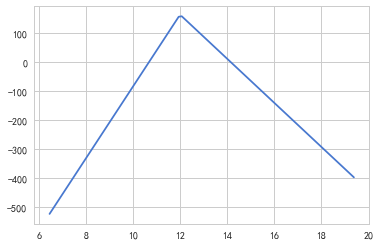

In [133]:
my_portfolio.plot_profitNloss(1)